<a href="https://colab.research.google.com/github/niczky12/medium/blob/bq_file_loads/tech/bigquery/benchmarks/bigquery_load_benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigQuery Load Time Benchmarks

Here we'll compare the the load times into BigQuery for different file formats and sizes. This includes AVRO, CSV, CSV.GZIP and PARQUET files.

## Import packages


In [1]:
pip install pandavro

In [36]:
from sklearn import datasets
import pandas as pd
import datetime
import hashlib
import pandavro
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import (bigquery, storage)
import uuid

In [9]:
# authenticate to GCP
from google.colab import auth
auth.authenticate_user()

In [27]:
# Create a test bucket in the UI and define its name hare
BUCKET_NAME = "yetanothertestbucket-efas123d"

# also setup a local folder for copying files into
FOLDER = "data"

# config for BQ dataset
PROJECT_ID = "medium-279206"
LOCATION="europe-west2"
DATASET_NAME = "loadbench"

## Generate some dummy files

We will now creat some dummy dataframes to upload to GCS. I used `sklearn`'s `datasets.make_regression` function.

In [28]:
def make_int(x: int) -> int:
    return int(x * 100000)


def make_datetime(x: int) -> datetime.datetime:
    return datetime.datetime.fromtimestamp(abs(make_int(x)))


def make_string(x: int) -> str:
    return hashlib.sha1(str(x).encode()).hexdigest()


def make_char(x: int) -> str:
    return chr(97 + (make_int(x) % 26))


def col_name_formatter(x: int) -> str:
    return f"col_{x:04d}"


def make_random_dataset(
    rows: int,
    float_cols: int = 1,
    int_cols: int = 1,
    datetime_cols: int = 1,
    string_cols: int = 1,
    char_cols: int = 1,
) -> pd.DataFrame:

    functions = [
        lambda x: x,
        make_int,
        make_datetime,
        make_string,
        make_char,
    ]

    quantities = [
        float_cols,
        int_cols,
        datetime_cols,
        string_cols,
        char_cols,
    ]

    total_columns = sum(quantities)

    X, _ = datasets.make_regression(
        n_samples=rows, n_features=total_columns
    )

    df = pd.DataFrame(
        X,
        columns=[
            col_name_formatter(i)
            for i in range(total_columns)
        ],
    )

    start_index = 0

    for fn, quantity in zip(functions, quantities):
        if quantity == 0:
            continue

        end_index = start_index + quantity
        df.iloc[:, start_index:end_index] = df.iloc[
            :, start_index:end_index
        ].applymap(fn)
        start_index = end_index

    return df


df = make_random_dataset(5_000, 50, 50, 50, 50, 50)
large_df = pd.concat((df for _ in range(10)))

os.makedirs(FOLDER, exist_ok=True)

save_functions = {
    "csv": lambda df, fname: df.to_csv(
        f"{FOLDER}/CSV_{df.shape[0]}_{fname}.csv",
        index=False,
    ),
    "gzip": lambda df, fname: df.to_csv(
        f"{FOLDER}/GZIP_{df.shape[0]}_{fname}.csv.gzip",
        index=False,
        compression="gzip",
    ),
    "parquet": lambda df, fname: df.to_parquet(
        f"{FOLDER}/PARQUET_{df.shape[0]}_{fname}.parquet",
        index=False,
    ),
    "avro": lambda df, fname: pandavro.to_avro(
        f"{FOLDER}/AVRO_{df.shape[0]}_{fname}.avro", df
    ),
}

for save_function in save_functions.values():
    for fname, data in zip(
        ("small", "large"), (df, large_df)
    ):
        save_function(data, fname)


## Comparing file sizes


In [29]:
file_pattern = r"CSV|GZIP|PARQUET|AVRO"
row_pattern = r"\d+"
file_names = [
    f"{FOLDER}/{f}"
    for f in os.listdir(FOLDER)
    if re.search(file_pattern, f)
]

file_info = []

file_size_mb = lambda fname: os.path.getsize(fname) / (
    2 ** 20
)

for fname in file_names:
    size = file_size_mb(fname)
    extension = re.search(file_pattern, fname).group()
    rows = int(re.search(row_pattern, fname).group())
    size = file_size_mb(fname)

    file_info.append(
        {
            "fname": fname,
            "extension": extension,
            "rows": rows,
            "size": size,
        }
    )

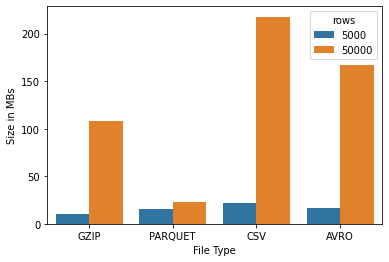

In [30]:
# visualise the file sizes
ax = sns.barplot(
    x="extension",
    y="size",
    hue="rows",
    data=pd.DataFrame(file_info),
)
ax.set(xlabel="File Type", ylabel="Size in MBs")
plt.show()

In [31]:
# copy all the files to the bucket
cmd = f"gsutil -m rsync {FOLDER}/ gs://{BUCKET_NAME}/"
os.system(cmd)

0

In [26]:
dataset_command = f"""bq --location={LOCATION} mk \
--dataset \
--default_table_expiration 3600 \
--description "Benchmarking bigquery load times" \
{PROJECT_ID}:{DATASET_NAME}"""

os.system(dataset_command)

0

In [41]:
client = storage.Client(project=PROJECT_ID)
bq_client = bigquery.Client(project=PROJECT_ID)

def add_prefix(filename):
    return f"{uuid.uuid4().hex}_{filename}"

def benchmark(blob_name,
    job_config,
    repeat=1, duplicate=1,
    bucket_name=BUCKET_NAME,
    dataset_name=DATASET_NAME,
    storage_client=client,
    bigquery_client=bq_client):

    bucket = client.get_bucket(bucket_name)
    from_blob = bucket.get_blob(blob_name)

    # copy the files
    new_path = add_prefix(blob_name)

    for i in range(duplicate):
        new_name = f"{new_path}/{blob_name}_{i:05d}"
        bucket.copy_blob(from_blob, bucket, new_name=new_name, client=client)


    for i in range(repeat):
        table_name = add_prefix(f"{i:05d}")
        table_ref = bq_client.dataset(dataset_name).table(
            table_name
        )
        job = bq_client.load_table_from_uri(
            f"gs://{BUCKET_NAME}/{new_path}/*",
            table_ref, job_config=job_config
        )

    return job


In [39]:
job_config = bigquery.LoadJobConfig()
job_config.source_format = bigquery.SourceFormat.CSV
job_config.skip_leading_rows = 1
job_config.autodetect = True


blob_name = "CSV_5000_small.csv"

In [42]:
j = benchmark(blob_name, job_config)

In [43]:
j

In [44]:
j.wait()

AttributeError: ignored

In [45]:
j.result()

In [46]:
j.ended

datetime.datetime(2020, 6, 24, 6, 50, 22, 454000, tzinfo=<UTC>)

In [47]:
j.started

datetime.datetime(2020, 6, 24, 6, 50, 14, 532000, tzinfo=<UTC>)